In [256]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline

In [257]:
data=pd.read_csv("train.csv")

In [258]:
data.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


# General analysis on the data

In [234]:
data.info(), data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

(None,
                AB            AF           AH          AM          AR  \
 count  617.000000    617.000000   617.000000  617.000000  617.000000   
 mean     0.477149   3502.013221   118.624513   38.968552   10.128242   
 std      0.468388   2300.322717   127.838950   69.728226   10.518877   
 min      0.081187    192.593280    85.200147    3.177522    8.138688   
 25%      0.252107   2197.345480    85.200147   12.270314    8.138688   
 50%      0.354659   3120.318960    85.200147   20.533110    8.138688   
 75%      0.559763   4361.637390   113.739540   39.139886    8.138688   
 max      6.161666  28688.187660  1910.123198  630.518230  178.943634   
 
                AX          AY          AZ           BC           BD   ...  \
 count  617.000000  617.000000  617.000000   617.000000    617.000000  ...   
 mean     5.545576    0.060320   10.566447     8.053012   5350.388655  ...   
 std      2.551696    0.416817    4.350645    65.166943   3021.326641  ...   
 min      0.699861    

The dataset I've chosen has 58 columns, among which 2 are categorical (EJ, Id) and the other ones are numerical of type float, except for "Class", the target variable, which thakes values {0,1}.  <br>
The numerical columns take values in very different ranges.

Target variable distribution:

In [259]:
print(Counter(data['Class']))
print("Class ratio: ", np.bincount(data['Class'])[0]/np.bincount(data['Class'])[1])

Counter({0: 509, 1: 108})
Class ratio:  4.712962962962963


The classes are imbalnced: the negative class is almost 5 times the positive class, therefore it will be necessary to weight them properly.

Missing values:

In [260]:
missings=data.isnull().sum()
print("Columns with missing values:\n",missings[missings>0]) #there are 9 columns with missing values

Columns with missing values:
 BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64


In [261]:
missings1=data[data.Class==1].isnull().sum()
missings0=data[data.Class==0].isnull().sum()
print(missings1[missings1>0])
print(missings0[missings0>0])

CC    1
EL    6
FC    1
FS    1
dtype: int64
BQ    60
CB     2
CC     2
DU     1
EL    54
FL     1
FS     1
GL     1
dtype: int64


Checking if there are duplicates using 'Id' column:

In [262]:
len(data.Id.unique())==len(data)

True

# Features distribution

In [97]:
numerical_f=list(data.select_dtypes(include=["float64"]).columns)

Inspecting the distribution of each feature:

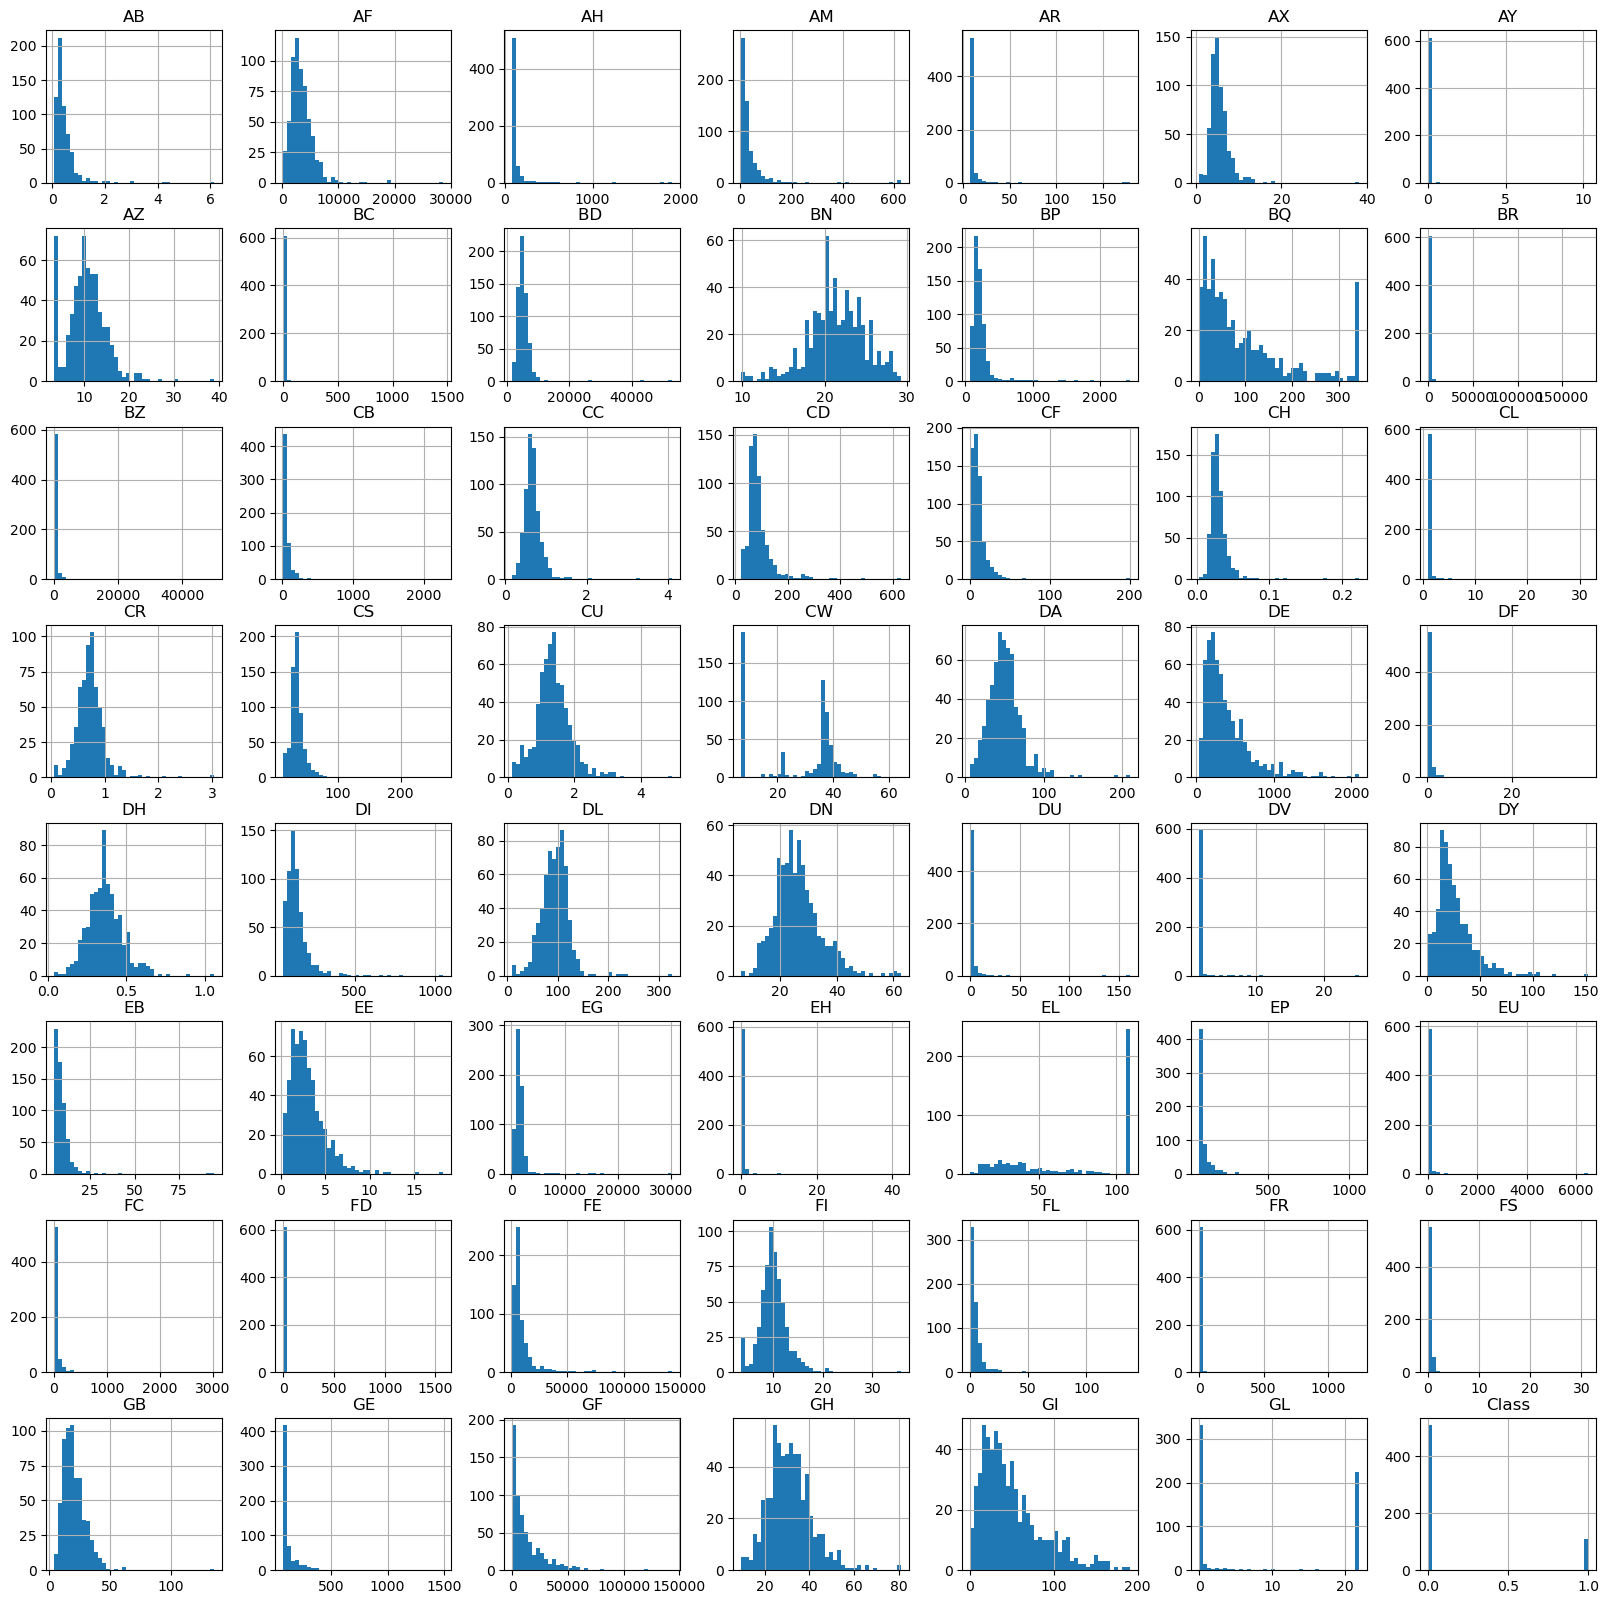

In [98]:
data.hist(bins=40, figsize = [20,20])
plt.show()

Outliers detection: I will compute the IQR. I'm not using boxplots due to the high number of features.

In [237]:
def get_outliers(c):
    "Function that returns outlier values of a given column s"
    q1 = np.nanpercentile(c, 25) #first quartile.
    q3 = np.nanpercentile(c, 75) #second quartile.
    #median=np.percentile(c, 50)
    iqr = (q3 - q1)  #inter quartile range.
    outliers=[el for el in c if (el < q1 - 1.5 * iqr) or (el > q3 + 1.5 * iqr)]
    return outliers
outliers={}
for col in data.columns:
    if(col=="Id" or col=='Class' or col=='EJ'):
        continue
    outliers[col]=get_outliers(data[col]) #the list contains the name of the column with outlier values and the outlier values 

In [238]:
no_outliers=[col for col in outliers.keys() if len(outliers[col])==0]
print("Column without outliers: ", no_outliers)
print("Number of columns with outliers: ", len(outliers)-len(no_outliers))

Column without outliers:  ['CW ', 'EL', 'GL']
Number of columns with outliers:  52


Most of the columns have outlier values, only 3 don't have them.

In [101]:
for col in no_outliers:
    print(col, " range: ", data[col].min(), data[col].max())

CW   range:  7.03064 64.521624
EL  range:  5.394675 109.125159
GL  range:  0.001129278 21.978


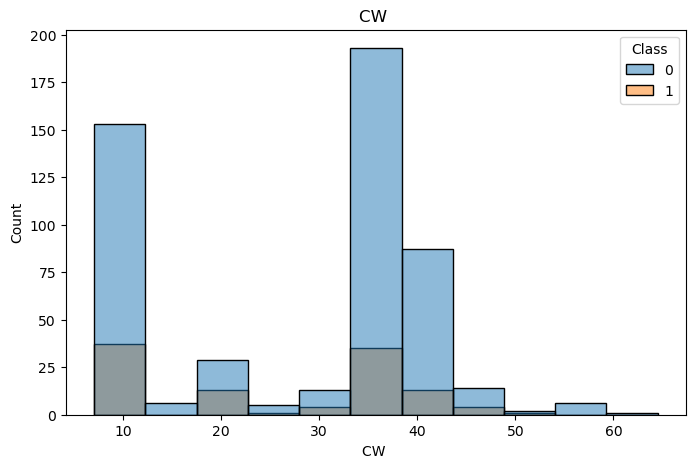

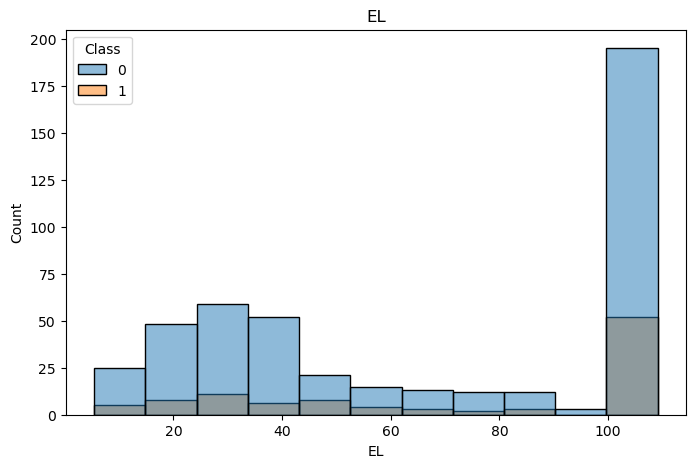

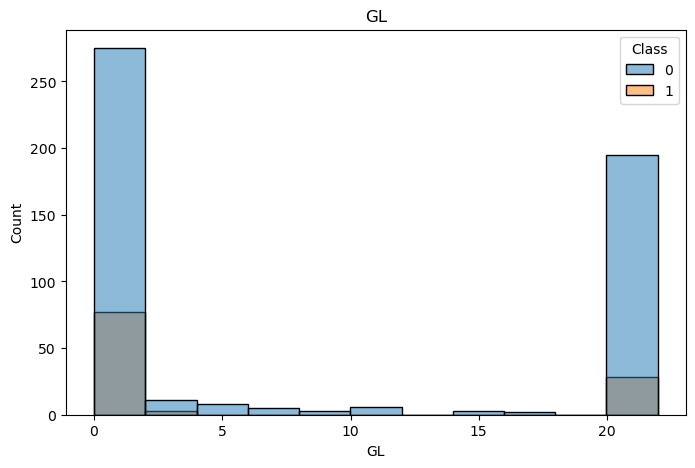

In [102]:
for numf in no_outliers:
    fig, axes = plt.subplots(1, 1, figsize=(8, 5))
    sns.histplot(ax=axes, x=data[numf], hue=data.Class)
    axes.set_title(numf)

# Correlation between features

Having correlated features makes numerically unstable linear models and in general it increases the complexity of the model. Therefore I will try to drop some of the features highly correlated with other ones.

<AxesSubplot:>

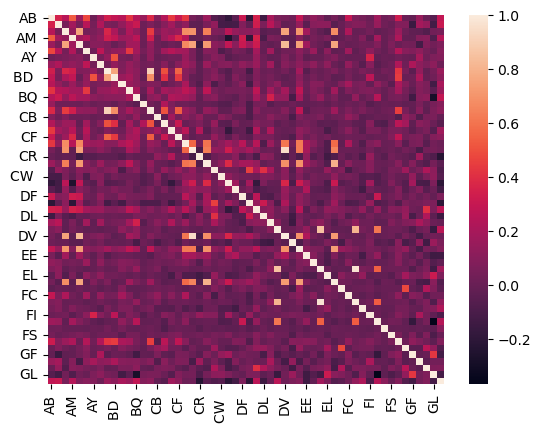

In [103]:
corr=data.corr()
sns.heatmap(corr)

Correlation with target:

<AxesSubplot:>

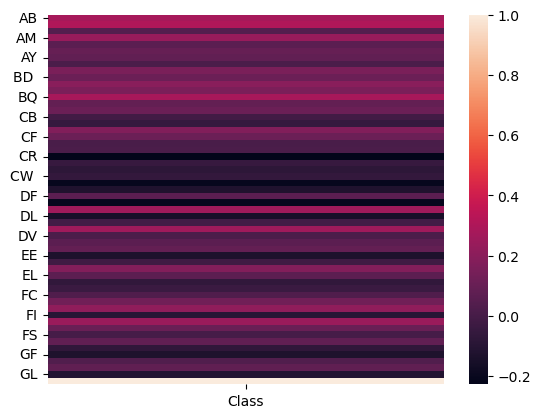

In [104]:
sns.heatmap(data.corr().loc[:,['Class']])

In [105]:
print(corr['Class'].abs().sort_values(ascending=False))

Class    1.000000
AF       0.302638
BQ       0.281257
AB       0.280612
DU       0.261000
DI       0.260760
FL       0.244185
AM       0.239170
CR       0.227547
FE       0.216359
DH       0.206839
DA       0.204612
BN       0.198283
EH       0.179855
CD       0.171304
BP       0.157286
BC       0.155882
DL       0.147716
EE       0.135324
FD       0.131100
GF       0.128208
DE       0.124977
GL       0.119202
BZ       0.112423
BD       0.112184
CF       0.109748
FR       0.104099
AX       0.097616
FI       0.094327
BR       0.088554
EB       0.088005
GB       0.083343
CU       0.083185
AY       0.082420
GI       0.076894
GE       0.070766
EP       0.068383
EL       0.067947
AR       0.064380
DF       0.064272
DY       0.062734
CW       0.062639
CC       0.054723
CS       0.047438
AH       0.044645
EU       0.039739
GH       0.033540
FC       0.030689
EG       0.024610
CL       0.016852
DV       0.015477
CB       0.014777
AZ       0.013516
DN       0.008478
CH       0.008144
FS       0

In [106]:
to_drop=['EH','FD ','BZ','CL','AH','DV','EB','EP','CS']

In [107]:
corr_sorted =corr.abs().unstack().sort_values(ascending=False) #looking at columns with highest correlation
correlated_couples=corr_sorted[55:][corr_sorted[55:]>0.7] #excluding the diagonal of corr, since the correlation of a variable with itself is of course 1
print(correlated_couples)

Class  Class    1.000000
EH     FD       0.971152
FD     EH       0.971152
CL     DV       0.948991
DV     CL       0.948991
BC     BZ       0.907981
BZ     BC       0.907981
DU     EH       0.850957
EH     DU       0.850957
AR     DV       0.823012
DV     AR       0.823012
FD     DU       0.805989
DU     FD       0.805989
EP     CS       0.794158
CS     EP       0.794158
EP     AR       0.754615
AR     EP       0.754615
BD     BC       0.753051
BC     BD       0.753051
AH     AR       0.749794
AR     AH       0.749794
AH     DV       0.746715
DV     AH       0.746715
CL     AR       0.745504
AR     CL       0.745504
       EB       0.741000
EB     AR       0.741000
EP     EB       0.729374
EB     EP       0.729374
CS     AR       0.720853
AR     CS       0.720853
DV     EP       0.716778
EP     DV       0.716778
EB     AH       0.705110
AH     EB       0.705110
dtype: float64


There are 17 couples of features with correlation >0.7, among which 6 have correlation >0.8

In [108]:
count=0
corrf=[]
for index, it in correlated_couples.items():
    if(count%2==0):
        corrf.append(index)
    count+=1

In [109]:
print(corrf)
unique_f=['EH','FD ', 'CL', 'DV','BC','BZ','DU','AR','CS','EP', 'BD', 'AH','EB']

[('Class', 'Class'), ('FD ', 'EH'), ('DV', 'CL'), ('BZ', 'BC'), ('EH', 'DU'), ('DV', 'AR'), ('DU', 'FD '), ('CS', 'EP'), ('AR', 'EP'), ('BC', 'BD '), ('AR', 'AH'), ('DV', 'AH'), ('AR', 'CL'), ('EB', 'AR'), ('EB', 'EP'), ('AR', 'CS'), ('EP', 'DV'), ('AH', 'EB')]


# Transforming the only categorical variable

The variable is binary, therefore I choose to one-hot encode it. This transformation can be done before splitting the data in train and test set because every row is transformed independently from the other ones.

In [264]:
data['EJ'] = data['EJ'].map({'A':0,'B':1})

In [227]:
for cat in cat_var:
    for_dummy = data.pop(cat)
    data = pd.concat([data, pd.get_dummies(for_dummy, prefix=cat)], axis=1)

# Missing values imputation

In [240]:
cols_with_nans=data.isnull().sum()[data.isnull().sum()>0].index

Checking the distribution of each column with missing values

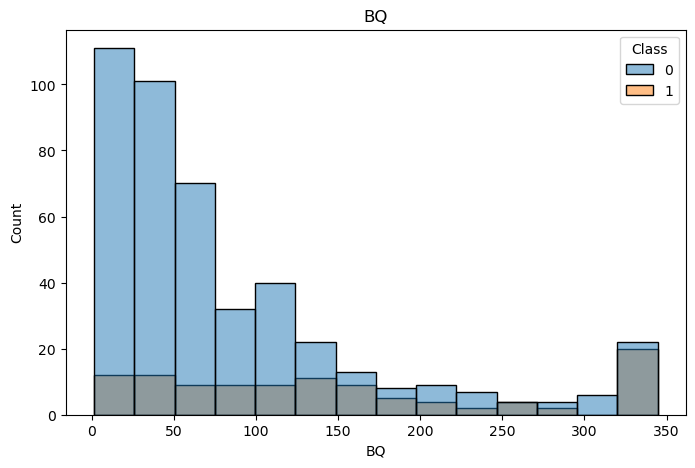

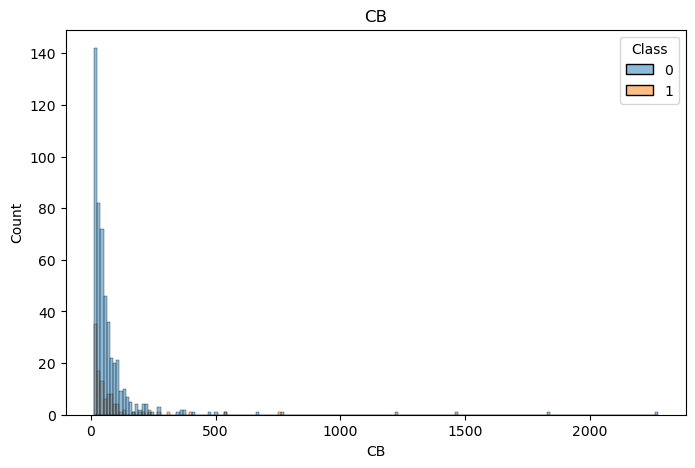

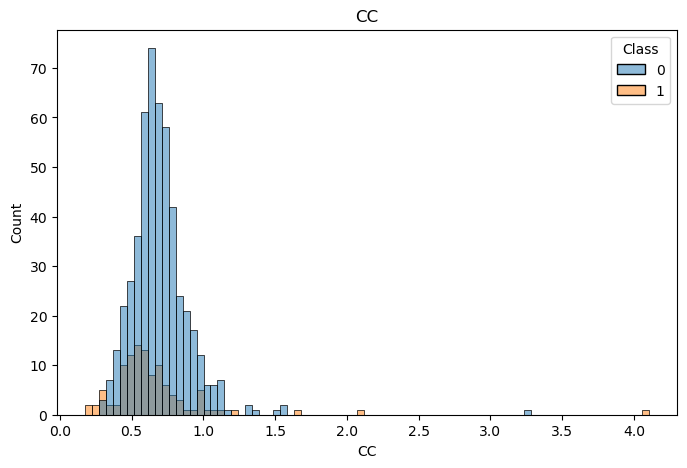

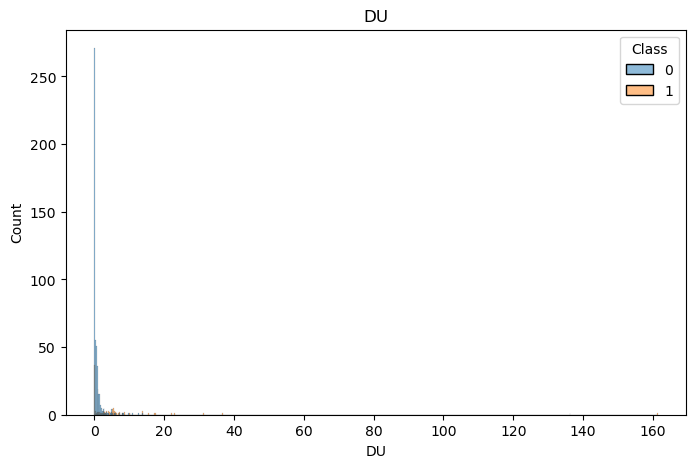

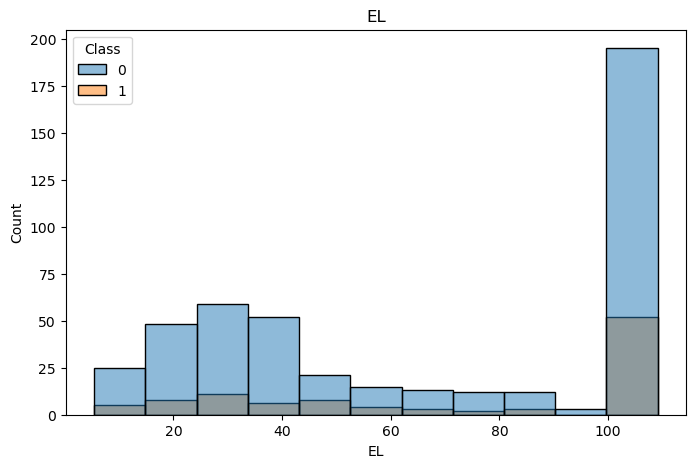

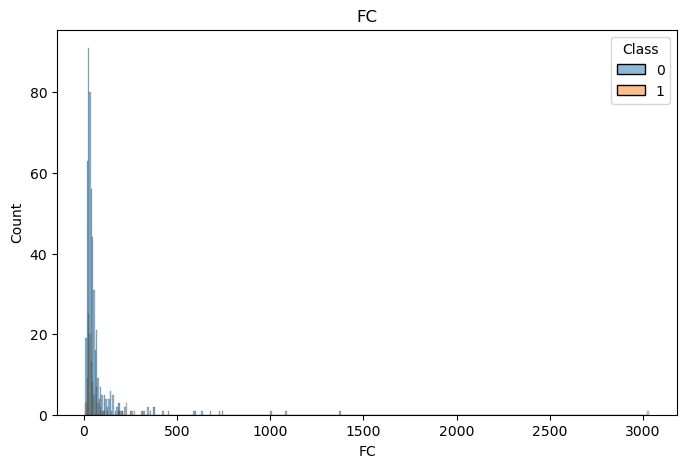

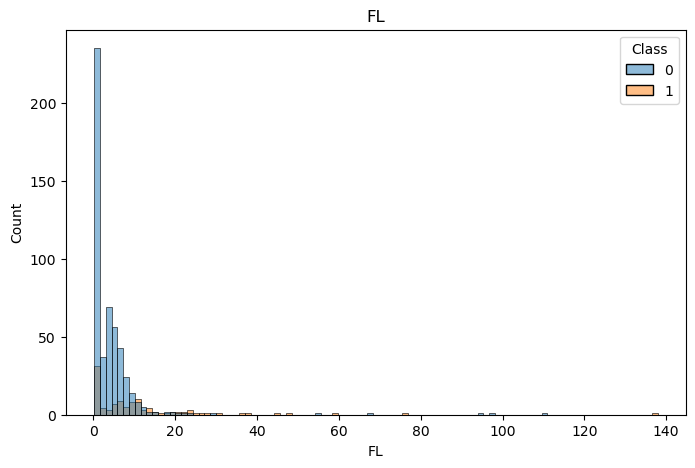

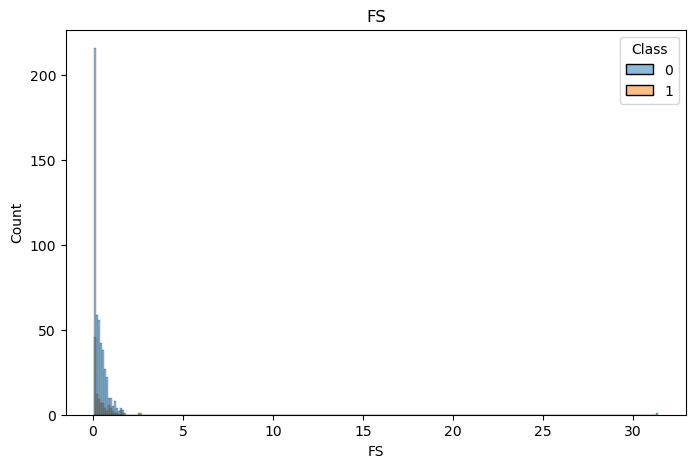

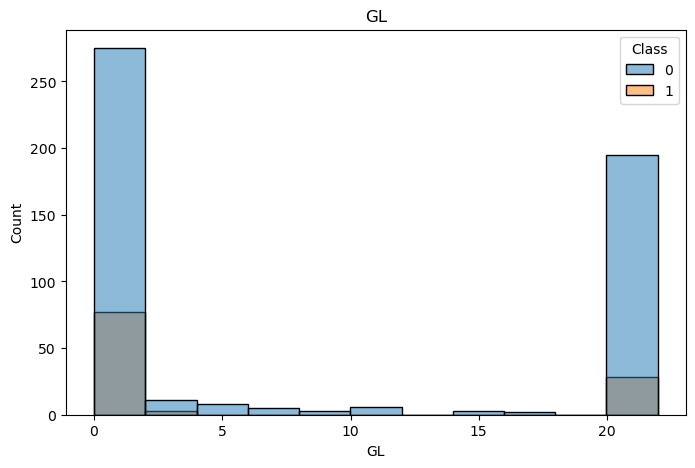

In [113]:
for col in cols_with_nans:
    fig, axes = plt.subplots(1, 1, figsize=(8, 5))
    sns.histplot(ax=axes, x=data[col], hue=data.Class)
    axes.set_title(col)

For GL,CB,CC,DU,EL,FC,FL,FS I fill missing values with the median given the presence of outlier values. For GL and EL, that doesn't have outlier values, given their distribution, that is not symmetric, I replace missing values of GL with the median as well, while those of EL with the mode.

In [202]:
for col in cols_with_nans:
        if(col=='EL'):
                #data[col]=data[col].fillna(data[col].mode()[0])
                data[col]=data[col].fillna(data[col].median())
        data[col]=data[col].fillna(data[col].median())

With SimpleImputer--> adding an indicator variable

In [228]:
def missings_dummy(s):
    if(pd.notnull(s)):
        return 0
    else:
        return 1
for col in cols_with_nans:
    data[col+'_missing']=data[col].apply(missings_dummy)

In [241]:
imp1=SimpleImputer(strategy='median')
for col in cols_with_nans:
        data[col]=imp1.fit_transform(data[col].values.reshape(-1,1))[:,0]

In [242]:
data.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

In [243]:
data.isnull().sum()[data.isnull().sum()>0] #checking that missing values have been filled

Series([], dtype: int64)

Dropping NaNs:

In [125]:
data=data.dropna()

Date column:

In [192]:
#Finding how many years are considered:
def extract_year(r):
    if(r=='Unknown'):
        return 'Unknown'
    ss=r.split('/')
    return ss[-1]
data['year']=data.Epsilon.apply(extract_year)
print(data.year.unique())

['2019' 'Unknown' '2020' '2018' '2014' '2012' '2016' '2017']


Dropping 'Id' column and saving the dataset:

In [244]:
data.drop(['Id'], axis=1).to_csv("Train_set_halfprep.csv", index=False)